## TFIM (EE, 分割する, 横磁場)

\[
H = - J \sum_i S_i^z S_{i+1}^z \;-\; h_x \sum_i S_i^x
\]


In [66]:
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
from pathlib import Path
from datetime import datetime
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as pe

In [72]:
# ============
## 準備
T_total, nt = 20.0, 400
tlist = np.linspace(0.0, T_total, nt)
# ============
## 実行部
# cut_pos = N // 2 - 1
# sx, sy, sz = [0.5*M for M in (qt.sigmax(), qt.sigmay(), qt.sigmaz())]
# I2 = qt.qeye(2)
# # iのスピン演算子に関するハミルトニアンの項
# Sx = [op_at(i, sx) for i in range(N)]
# Sy = [op_at(i, sy) for i in range(N)]
# Sz = [op_at(i, sz) for i in range(N)]
# # ハミルトニアン
# ## 分割するボンド
# H_cut_unit = H_exchange(cut_pos)
# ## それ以外のボンド
# H_exchange_unit = sum(H_exchange(i) for i in range(N) if i != cut_pos)
# ## 横磁場項
# H_trans_unit = sum(H_trans(i) for i in range(N))
# H_full = J * (H_exchange_unit + H_cut_unit) - h[0] * H_trans_unit
# H_static = J * H_exchange_unit - h[0] * H_trans_unit
# left_sides = [i for i in range(cut_pos + 1)]
# _, psi_ground = H_full.groundstate(sparse=True)
# solver_opts = dict(store_states=False, progress_bar = None, rtol = 1e-6, atol=1e-8, nsteps=20000)
# ============


# まとめて N, h, J, T_cutをパラメータとして 
def simulate_EE(N, hx, J, T_cut):
    cut_pos = N // 2 - 1
    sx, sy, sz = [0.5*M for M in (qt.sigmax(), qt.sigmay(), qt.sigmaz())]
    I2 = qt.qeye(2)

    # ============
    # ハミルトニアン構築
    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sy = [op_at(i, sy) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]
    
    # イジング相互作用項
    def H_exchange(i):
        # 周期境界条件あり(正方格子との比較はしずらい)
        if (i == N - 1):
            return (Sz[i] * Sz[0])
        # # 周期境界条件なし(正方格子との比較に使う？)
        # if i = N -1 
        #     return (S[i][2])
        return (Sz[i] * Sz[i+1])
    
    # 横磁場項
    def H_trans(i):
        return Sx[i]
    # ============

    H_cut_unit = H_exchange(cut_pos)
    H_exchange_unit = sum(H_exchange(i) for i in range(N) if i != cut_pos)
    H_trans_unit = sum(H_trans(i) for i in range(N))
    H_full = J * (H_exchange_unit + H_cut_unit) - hx * H_trans_unit
    
    # ============
    # 分割(真ん中で割る)
    def ramp(t, T_cut):
        if T_cut <= 0.0: return 1.0 if t <= 0.0 else 0.0
        if t <= 0.0: return 1.0
        if t >= T_cut: return 0.0
        return 1.0 - t / T_cut
    
    def coeff(t, T_cut, J, args=None): 
        return J * ramp(t, T_cut)
    
    def make_H_time(T_cut: float, J: float):
        return [H_static, [J * H_cut_unit, lambda t, args: ramp(t, T_cut)]]
    
    def EE_op(t, state, args=None):
        left_sides = list(range(cut_pos + 1))
        rhoL = qt.ptrace(state, left_sides)
        return float(qt.entropy_vn(rhoL, base=2))
    
    def run_EE_curve(T_cut: float, J: float, psi0):
        H_time = make_H_time(T_cut, J)
        sol = qt.sesolve(H_time, psi0, tlist, e_ops=[EE_op], options=solver_opts)
        return np.array(sol.expect[0])

    H_static = J * H_exchange_unit - hx * H_trans_unitz
    
    # ============
    _, psi_ground = H_full.groundstate(sparse=True)
    solver_opts = dict(store_states=False, progress_bar = None, rtol = 1e-6, atol=1e-8, nsteps=20000)
    return run_EE_curve(T_cut, J, psi_ground)

x = tlist
# y = simulate_EE(N=6, hx=1.0, J = 1.0, T_cut = 0.0)

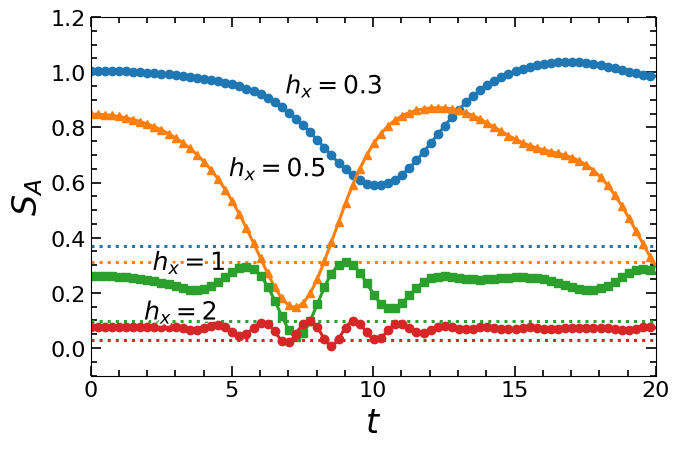

In [75]:
def label_at(ax, x, y, text, *, coord='data', dx_pt=8, fontsize=14, color=None):
    kw = dict(ha='left', va='center', fontsize=fontsize, xytext=(dx_pt, 0), textcoords='offset points', 
    path_effects=[pe.withStroke(linewidth=3, foreground='white')], clip_on=False, zorder=6)
    if color is not None:
        kw['color'] = color
    if coord == 'axes':
        ax.annotate(text, xy=(x, y), xycoords=ax.transAxes, **kw)
    else:
        ax.annotate(text, xy=(x, y), xycoords='data', **kw)

def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True, length=major_len, width=width)
    ax.tick_params(which='minor', length=minor_len, width=width)

def relax(ax, y):
    ax.axhline(y=y[0]/np.e, color=ax.lines[-1].get_color(), ls=':', lw=ax.lines[-1].get_linewidth())
    
markers = ['o', '^', 's'] 
fig, ax = plt.subplots(figsize=(6.9, 4.6))
inward_ticks(ax)

pos1 = { 
    # 0.0: (6.5, 1.1),
    0.3: (6.5, 0.95),   # (x=Tc, y=Final S_A)
    0.5: (4.5, 0.65),   # (x=Tc, y=Final S_A)
    1.0: (1.8, 0.31),
    2.0: (1.5, 0.13)}

hx_list = [0.3, 0.5, 1.0, 2.0]
# hx_list = [0.5]
for i, hx in enumerate(hx_list):
    x = tlist
    y = simulate_EE(N=6, hx=hx,J=1.0, T_cut=0.0)
    step = 5
    mk = markers[i % len(markers)]
    ln, = ax.plot(x, y, markevery=step, marker=mk, markersize=6.0)
    relax(ax,y)
    label_at(ax, *pos1[hx], fr"$h_x={hx:g}$", coord='data', fontsize=18)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams.update({
    "axes.labelsize": 18,   # 軸ラベル
    "xtick.labelsize": 16,  # 目盛り数字
    "ytick.labelsize": 16,
    "lines.linewidth": 2.2, # 線の太さ
    "axes.titlesize": 16,
})

ax.set_xlim(0.0, 20.0)
ax.set_xlabel(r"$t$", fontsize=24)
ax.set_ylim(-0.1, 1.2)
ax.set_ylabel(r"$S_A$", fontsize=24)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
fig.tight_layout()
OUTDIR = Path("charts/TFIM")
# fig.savefig(OUTDIR/"SA_cut.pdf", bbox_inches="tight", dpi=300)

plt.show()